In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("~/tools/ai/dataset/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [5]:
candidate_sentences['sentence'].sample(5)

2003    it is the highest-grossing animated film in south korea, denmark, and venezuela.
4269                                     the missing items included a jansport backpack.
959             the animator usually starts by creating a 3d polygon mesh to manipulate.
2064                                   the fox fanfare was also re-orchestrated in 1981.
4294                 the discs' extras include outtakes, audio commentary, a documentary
Name: sentence, dtype: object

In [6]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [8]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [9]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:35<00:00, 121.64it/s]


In [10]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [13]:
# The pattern defined in the function tries to find the ROOT word 
# or the main verb in the sentence. Once the ROOT is identified, 
# then the pattern checks whether it is followed by a 
# preposition (‘prep’) or an agent word. 
# If yes, then it is added to the ROOT word.
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [12]:
get_relation("John completed the task")

'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:34<00:00, 125.27it/s]


In [15]:
pd.Series(relations).value_counts()[:50]
# It turns out that relations like “A is B” and “A was B” 
# are the most common relations. However, 
# there are quite a few relations that are more associated 
# with the overall theme – “the ecosystem around movies”. 
# Some of the examples are “composed by”, “released in”, 
# “produced”, “written by” and a few more.

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
has               31
became            31
become            29
released in       27
included          26
called            22
produced          22
considered        20
made              20
had               20
been              18
be                18
scheduled         17
used              17
directed by       16
stars             16
written by        15
produced by       14
wrote             14
hired             14
set               14
went              13
introduced in     13
received          13
wanted            12
began             11
began in          11
won               11
gave              10
sold              10
features          10
opened             9
produced in        9
reported           9
gives              9
used in            9
includes           9
known as     

In [16]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [17]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [19]:
# plt.figure(figsize=(12,12))

# pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

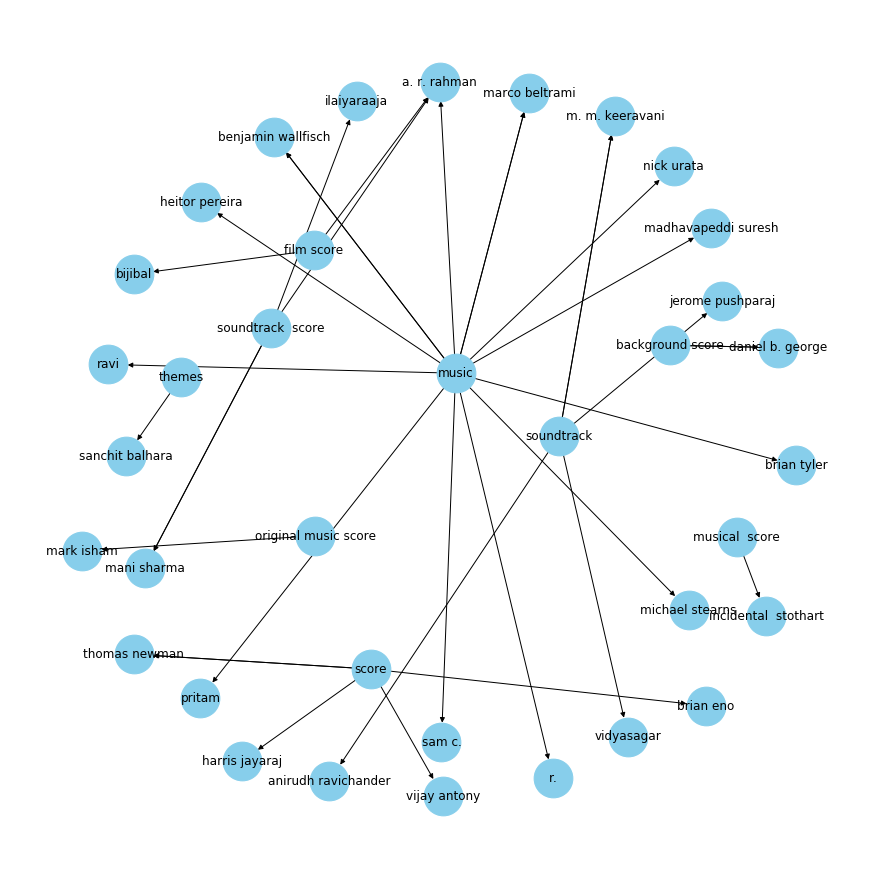

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

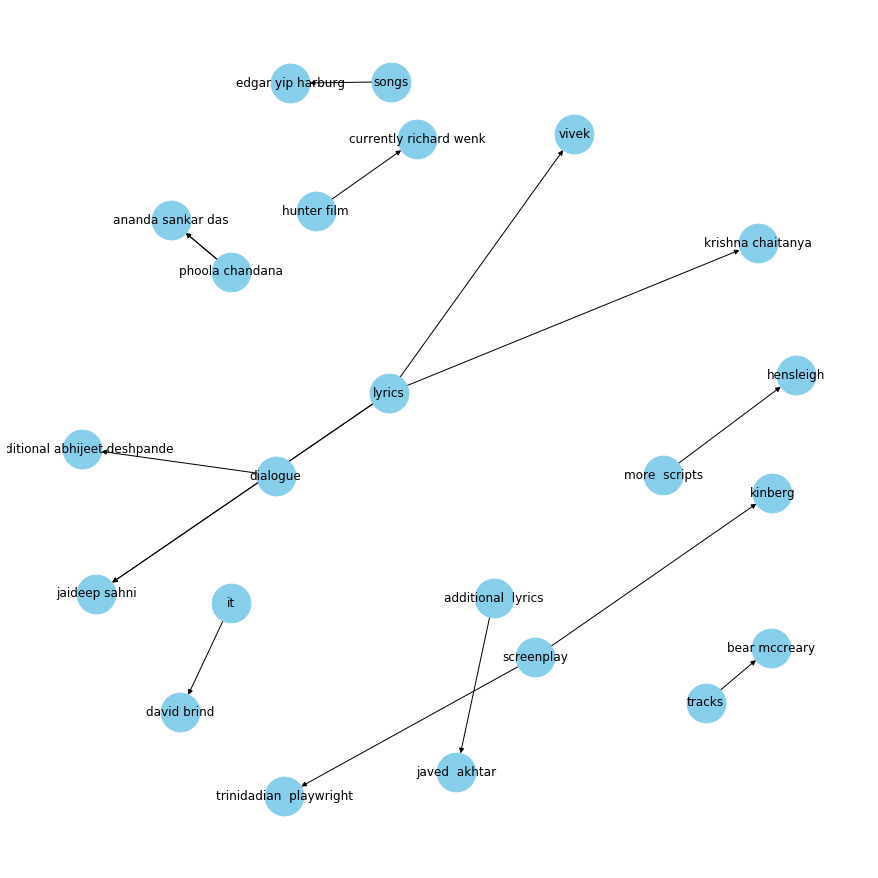

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

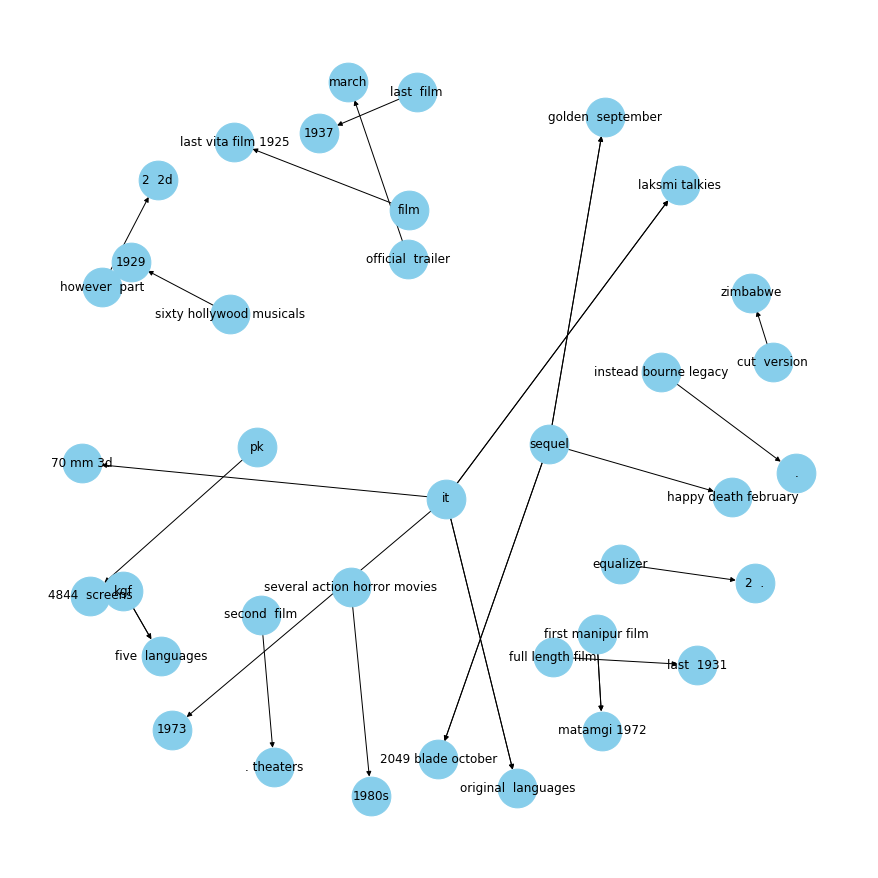

In [22]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()